# Background and Tools
There are two algorithms with similar names, which makes them prone to confusion although they have different purposes and follow different learning paradigms. One is in fact a clustering algorithm, k-Means, which in an unsupervised manner finds k clusters in a data set. This is done by iteratively setting out / moving k cluster centers and grouping the points in the set closest into the cluster, while at the same time optimising the separation between the groups (clusters) of data points. The other is a classifier, k-NN, which in its basic conceptual form does not actually do anything to fit a model to the given data, it simply finds the k nearest neighbours in the entire data set to an unseen data point, given some distance measure, and assigns it the class of the majority of the k samples. In actual implementations, other techniques are used to structure the data somewhat, so that the search for the closest points only has to be carried out in a part of the data set. However, it can be called supervised, as it is given the class labels of the data points it works with to do this pre-processing.

You will in this assignment work with a simplified version of the MNIST handwritten numbers dataset provided by SciKitLearn (sklearn.datasets.digits) and inspect and modify it with UMAP, calculate the cosine similarity of each data sample against the means over the different classes, and later both cluster it with k-Means as well as use the k-NN classifier on it, to then run different evaluation tools. The idea is to have used UMAP (as one example of a tool for dimensionality reduction), done a matrix multiplication in Python / Numpy, understand the different elements of the SciKitLearn confusion matrix and evaluation reports, as well as to see what you can do to evaluate a clustering approach (which is not as naturally done as for a classification, where an answer is either wrong or correct). 

# Exercise 1: Getting started


### Exercise 1.1
Make sure to have all the necessary basic tools running with the ["Lab 0: Python intro"](https://canvas.education.lu.se/courses/32297/pages/lab-0-python-intro) exercise. If not already included in your setup, install UMAP (e.g. with ```pip install umap-learn```, see https://umap-learn.readthedocs.io/en/latest/basic_usage.html for some hints).

In [1]:
# Install with pip install scikit-learn pandas seaborn umap-learn IProgress
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, metrics
from collections import Counter # For majority counting, but is not strictly necessary
import matplotlib.pyplot as plt 
import numpy as np

import seaborn as sns
import pandas as pd
import umap

### Exercise 1.2
Load the digits dataset from the datasets provided in SciKitLearn. [The python tutorial by Dennis Medved](Python_introduction.ipynb) can provide you with code snippets and inspiration to this and later parts of the assignment.

Inspect the data, plot some sample images (use matplotlib) and be prepared to answer questions about the dataset.

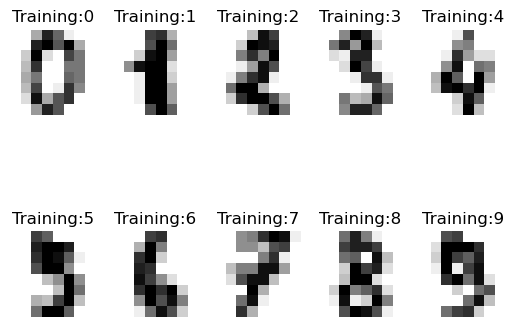

In [20]:
from sklearn import datasets, svm, metrics
import matplotlib.pyplot as plt
digits = datasets.load_digits()
digits.data
digits.data.shape

images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation = 'nearest')
    plt.title('Training:%i'%label)



### Exercise 1.3
Create and train (fit) a UMAP-reducer, then transform and visualise your data, e.g. doing something like:


C:\Users\luanp\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


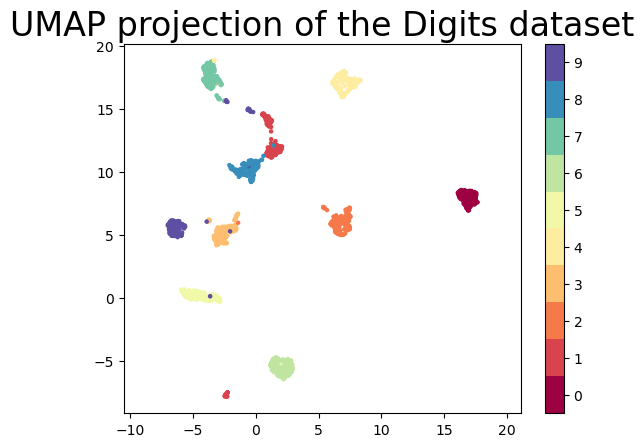

In [21]:
########### Example code ###########
reducer = umap.UMAP(random_state=42)
reducer.fit(digits.data)
embedding = reducer.transform(digits.data)

plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24);



__Be prepared to explain, at least on a conceptual level, what it does__

# Exercise 2
Calculate the cosine-similarity (should be explained in lecture 2) of each sample against the means of the classes in the data set as following:

### Exercise 2.1
Calculate the "mean image" per class, ```mean_images``` 

mean_images shape: (10, 64)


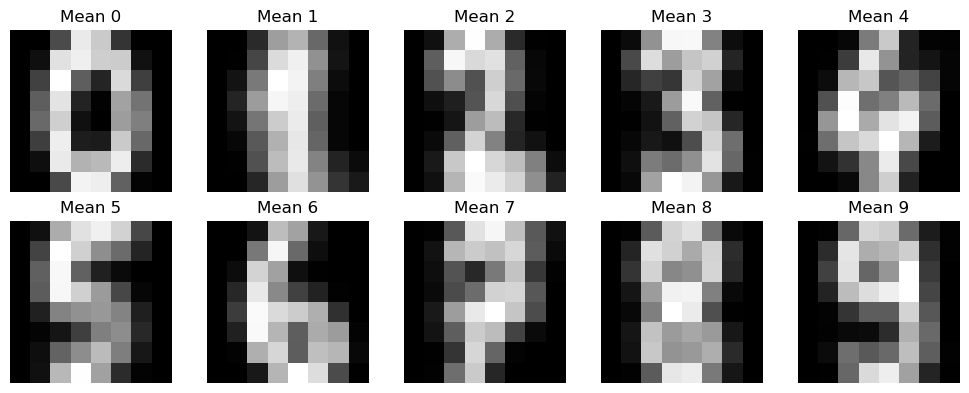

In [117]:
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()
mean_images = []
for label in range(10):

    class_images = digits.data[digits.target == label]
    mean_image = np.mean(class_images, axis = 0)
    mean_images.append(mean_image)

mean_images = np.array(mean_images)

print("mean_images shape:", mean_images.shape)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Mean {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()


### Exercise 2.2
Calculate the row-wise L2-norm for the raw data, i.e. the L2-norm over each image (check for example Numpy's linalg.norm for that) __and__ for the mean images you got from step the previous step.

In [24]:
mean_l2 = np.linalg.norm(mean_images, ord = 2,axis = 1)

print("mean_l2 shape:", mean_l2.shape, "values:", mean_l2)



mean_l2 shape: (10,) values: [57.21007138 56.76243429 56.13686576 55.6744608  55.96995923 54.6351969
 57.73202669 54.9510358  57.26457834 54.64989411]


### Exercise 2.3
Calculate the cosine similarity matrix, ```similarities``` of the normalised raw data and mean image matrices. See https://en.wikipedia.org/wiki/Cosine_similarity. as a reminder. 

In [29]:
def l2_normalize_rows(A, eps = 1e-12):
    norms = np.linalg.norm(A, axis = 1, keepdims = True)
    return A/(norms + eps)
X = digits.data
Xn = l2_normalize_rows(X)
Mn = l2_normalize_rows(mean_images)

S_data = Xn @ Xn.T
S_means = Mn @ Mn.T
S_sample_mean = Xn @ Mn.T

print("S_data shape:", S_data.shape)
print("S_means shape:", S_means.shape)
print("S_sample_mean shape:", S_sample_mean.shape)


S_data shape: (1797, 1797)
S_means shape: (10, 10)
S_sample_mean shape: (1797, 10)


### Exercise 2.4
Plot the closest and "furthest" sample (images) for each class, i.e. where cosine similarity is highest / lowest together with the respective mean image. You can use the following plot routine as inspiration to get the images out with some meta data (```similarities``` is the matrix with all the cosine similarities):

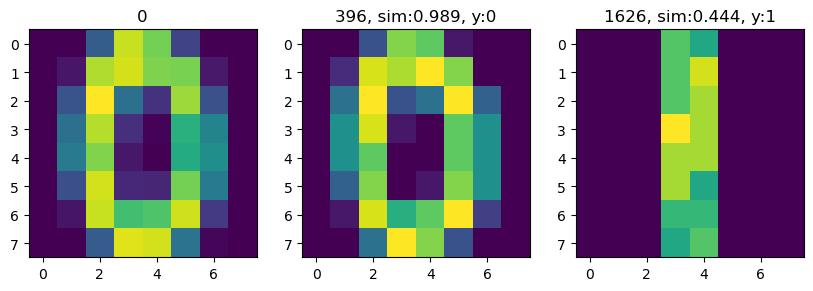

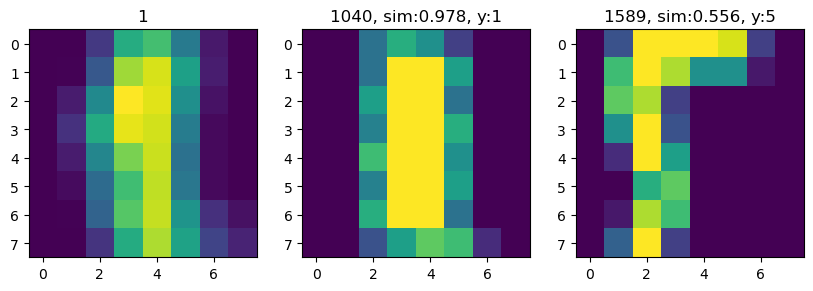

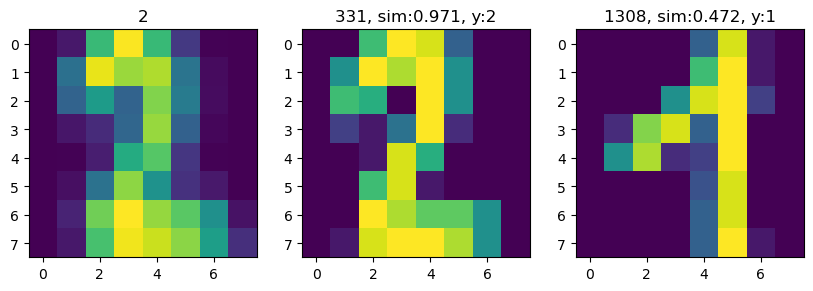

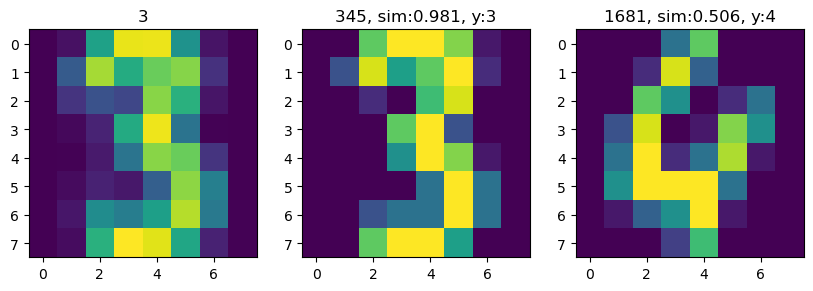

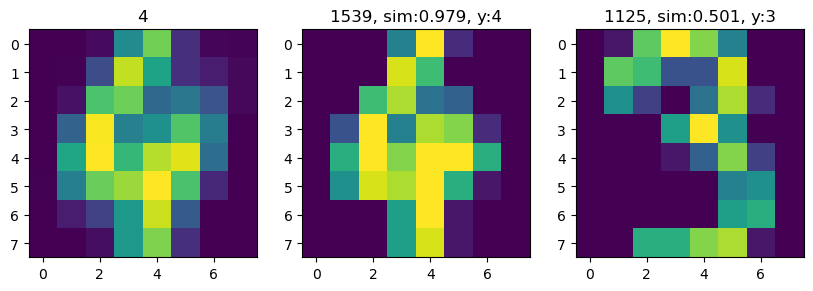

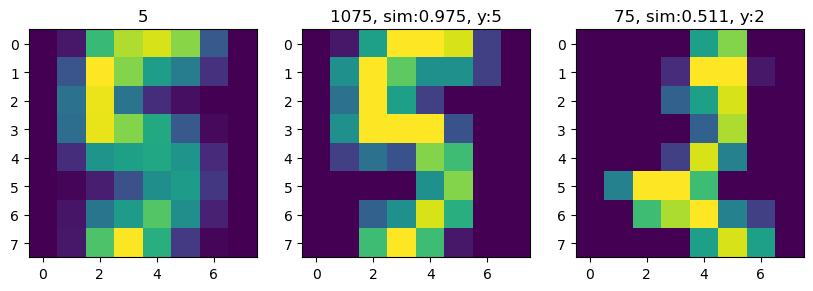

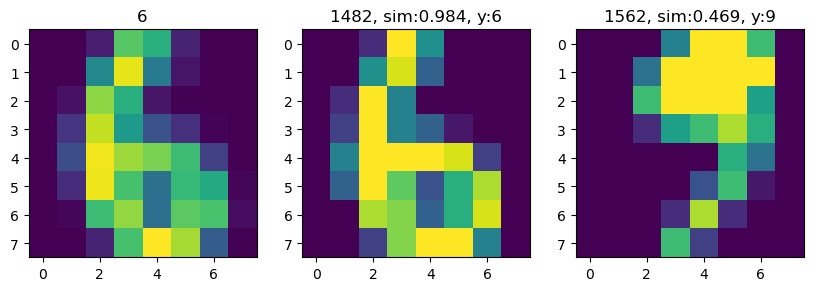

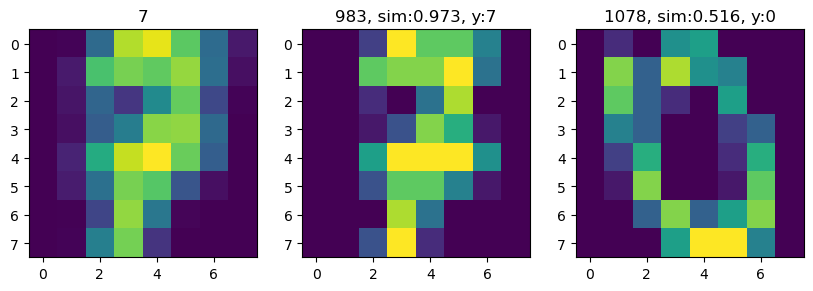

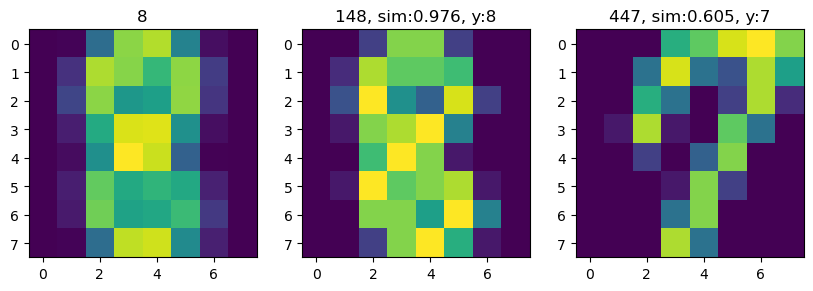

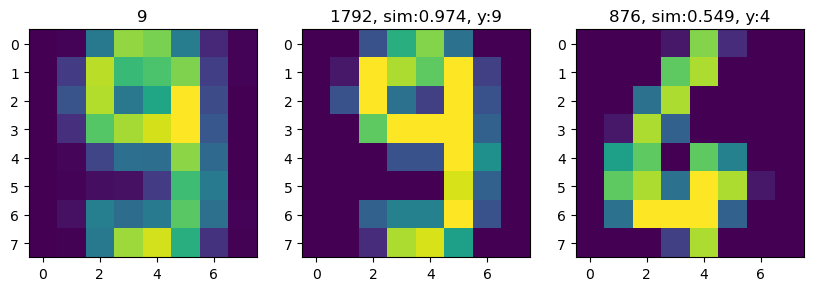

In [34]:
#import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity 
#define similarities
similarities = cosine_similarity(X,mean_images) 

for i in range(0, 10): 
    min_idx = np.argmin(similarities[:,i]) 
    max_idx = np.argmax(similarities[:,i])
    #plt.subplots(rows, cols,..)
    fig, axs = plt.subplots(1,3,figsize=(10,10))
    
    # reference image
    axs[0].set_title(f"{i}")        
    axs[0].imshow(mean_images[i].reshape(8,8))
    
    # image and data with highest similarity to reference
    axs[1].set_title(f"{max_idx}, sim:{similarities[max_idx, i]:.3f}, y:{digits.target[max_idx]}")
    axs[1].imshow(X[max_idx].reshape(8,8))
    
    # image and data with lowest similarity to reference
    axs[2].set_title(f"{min_idx}, sim:{similarities[min_idx, i]:.3f}, y:{digits.target[min_idx]}")
    axs[2].imshow(X[min_idx].reshape(8,8))

plt.show()

__Be prepared to explain__ what you see and reflect upon it!

# Exercise 3
Split your data set into 70% training data (features and labels), and 30% test data (this will be used for the classifiers below). Use the method ```train_test_split``` from ```klearn.model_selection```. Set the ```random_state=13  ``` and ```stratify``` on the labels (so that the test set has the same number of each label).

In [39]:
#import function of data split
from sklearn.model_selection import train_test_split
#define feature and label
X = digits.data
Y = digits.target
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size = 0.3,
    random_state = 13,
    stratify = Y
)

#print the data
print("Nmuber of training samples:", X_train.shape[0])
print("Number of test samoles:", X_test.shape[0])
print("Lable distrubition(training set):",np.bincount(Y_train))
print("Lable distrubition(test set):",np.bincount(Y_test))




Nmuber of training samples: 1257
Number of test samoles: 540
Lable distrubition(training set): [124 127 124 128 127 127 127 125 122 126]
Lable distrubition(test set): [54 55 53 55 54 55 54 54 52 54]


# Exercise 4: k-NN
Process the data with a k-NN classifier as follows: 

### Exercise 4.1
Set up a ```sklearn.neighbors.KNeighborsClassifier``` as it comes in SciKitLearn with ```n_neighbors = 5, algorithm = 'brute'``` and otherwise default parameters

In [60]:
#import method of KNN 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors = 5,
    algorithm = 'brute'
)



### Exercise 4.1
Prepare the classifier ("fit a model") with your training data

In [61]:
knn.fit(X_train, Y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'brute'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


### Exercise 4.2
 Apply your classifier to the test data, i.e., get predictions for the test data
 

In [62]:
from sklearn.metrics import accuracy_score


Y_pred = knn.predict(X_test)
acc = accuracy_score(Y_test,Y_pred)
print("Accuracy:",acc)




Accuracy: 0.9851851851851852


Get the nearest neighbors and the corresponding distances in the training set for each test sample  

In [84]:
#Usage <distances, neighbors> = <classifier>.kneighbors( <test_features>) 

# *** Your code ***
distances,neighbors = knn.kneighbors(X_test)

nearest_dist = distances[:,0]
nearest_index = neighbors[:,0]

for i in range(5):
    print("Nearest neighbor index:", nearest_index[i])
    print("Nearest neighbor distance:", nearest_dist[i])

#print("Shape of distances:",distances)
#print("Shape of neighbors:",neighbors)


Nearest neighbor index: 874
Nearest neighbor distance: 26.457513110645905
Nearest neighbor index: 15
Nearest neighbor distance: 12.96148139681572
Nearest neighbor index: 341
Nearest neighbor distance: 16.401219466856727
Nearest neighbor index: 293
Nearest neighbor distance: 16.673332000533065
Nearest neighbor index: 218
Nearest neighbor distance: 14.933184523068078


Visualize the 5 nearest neighbors for a few test images (see tutorial)!

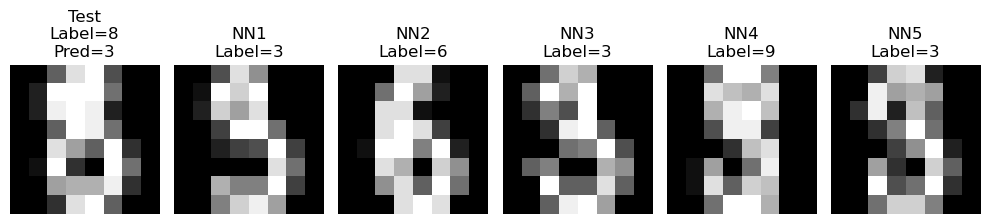

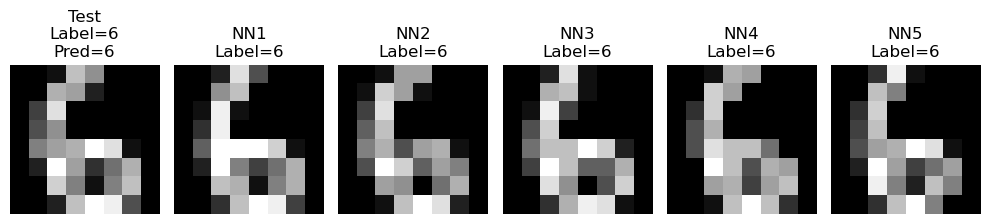

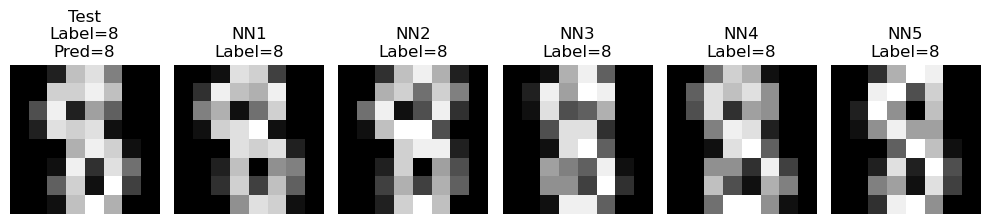

In [93]:

num_examples = 3  
for i in range(num_examples):
    fig, axes = plt.subplots(1, 6, figsize=(10, 3))
    
    axes[0].imshow(X_test[i].reshape(8, 8), cmap='gray')
    axes[0].set_title(f"Test\nLabel={Y_test[i]}\nPred={Y_pred[i]}")
    axes[0].axis('off')
    
    for j in range(5):
        neighbor_idx = neighbors[i, j]
        axes[j+1].imshow(X_train[neighbor_idx].reshape(8, 8), cmap='gray')
        axes[j+1].set_title(f"NN{j+1}\nLabel={Y_train[neighbor_idx]}")
        axes[j+1].axis('off')
    
    plt.tight_layout()
    plt.show()

        

### Exercise 4.3
Evaluate your classifier with the sklearn.metrics tools classification_report and confusion_matrix 

In [94]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

#print
print("Accuracy:",acc)
print("Confusion matrix:\n",confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred,digits=4))


Accuracy: 0.9851851851851852
Confusion matrix:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 52  0  0  0  0  1  0  0]
 [ 0  0  1 53  0  1  0  0  0  0]
 [ 0  0  0  0 53  0  0  0  1  0]
 [ 0  0  0  0  0 55  0  0  0  0]
 [ 0  0  0  0  0  0 54  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  2  0  1  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0  0  1 53]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     0.9649    1.0000    0.9821        55
           2     0.9811    0.9811    0.9811        53
           3     0.9815    0.9636    0.9725        55
           4     1.0000    0.9815    0.9907        54
           5     0.9821    1.0000    0.9910        55
           6     1.0000    1.0000    1.0000        54
           7     0.9818    1.0000    0.9908        54
           8     0.9608    0.9423    0.9515        52
           9     1.0000    0.9815    0.9907        54

    accuracy             

and

In [98]:
# USage metrics.confusion_matrix( <test_labels, <predicted_labels>)
# *****************
# *** Your code ***
# *****************
cm = confusion_matrix(Y_test,Y_pred)
print(" Confusion matrix:\n",cm)


 Confusion matrix:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 0 55  0  0  0  0  0  0  0  0]
 [ 0  0 52  0  0  0  0  1  0  0]
 [ 0  0  1 53  0  1  0  0  0  0]
 [ 0  0  0  0 53  0  0  0  1  0]
 [ 0  0  0  0  0 55  0  0  0  0]
 [ 0  0  0  0  0  0 54  0  0  0]
 [ 0  0  0  0  0  0  0 54  0  0]
 [ 0  2  0  1  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0  0  1 53]]


# Exercise 5: k-Means
Cluster the data with k-Means as follows:

### Exercise 5.1
Set up a k-Means instance (```sklearn.cluster.KMeans```) with ```n_clusters=10```, ```n_init=100``` and ```random_state=42```.

In [102]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=10,
    n_init=100,
    random_state=42
)

### Exercise 5.2
Apply the clustering approach

In [103]:
#<clusters> = <clustering>.fit(<train_features>)
# *** Your code ***
kmeans.fit(X_train)

train_clusters = kmeans.predict(X_train)

C:\Users\luanp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


### Exercise 5.3
Visualise the found cluster centers (you can get them using <clustering>.cluster_centers_); those are in principle also images, but maybe not as clearly interpretable as you would have hoped for. Compare what you see with the scatter plot you got from UMAP, i.e. find k-Means-clusters (visualised as cluster center images) and corresponding UMAP-plot-clusters (visualised as blobs or scattered dots in the plot) that are clearly distinct from everything else or others that seem to be "all the same" or at least very close.

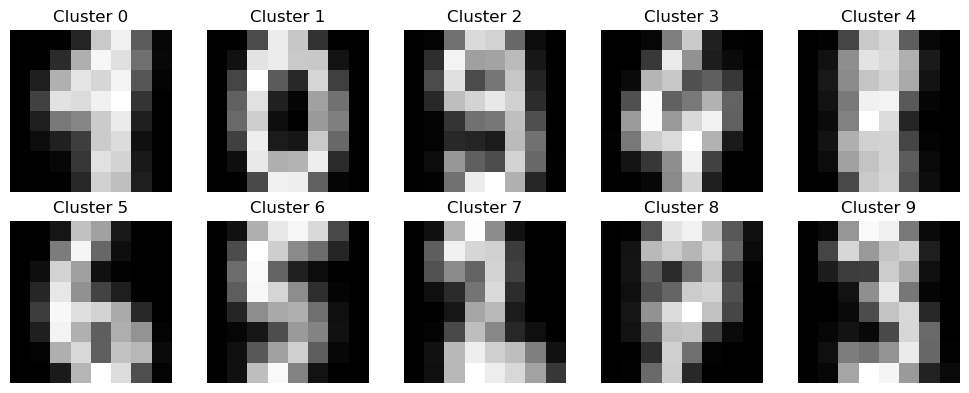

C:\Users\luanp\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


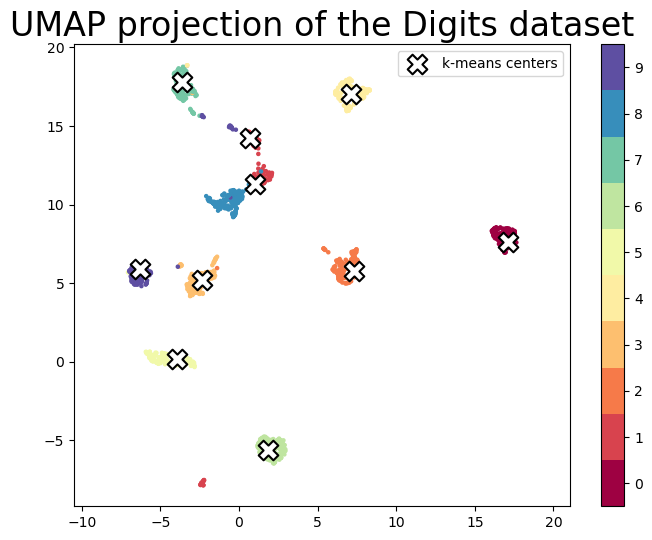

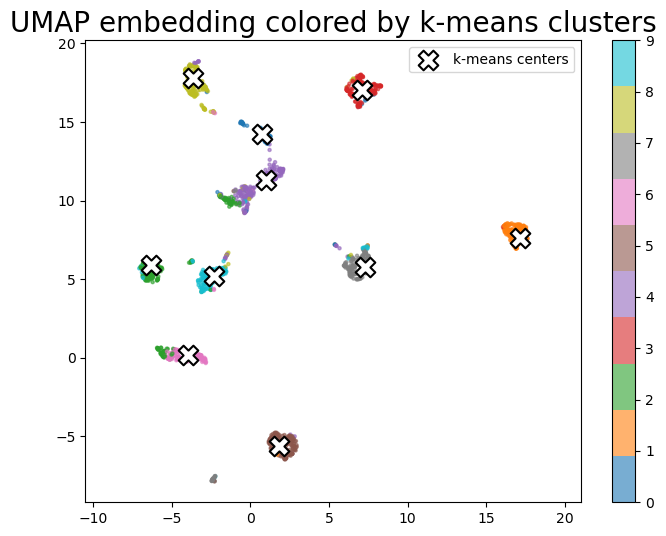

In [119]:
# *****************
# *** Your code ***
# *****************
import matplotlib.pyplot as plt
centers = kmeans.cluster_centers_.reshape(10,8,8)

fig,axes = plt.subplots(2,5,figsize=(10,4))
for i,ax in enumerate(axes.ravel()):
    ax.imshow(centers[i], cmap='gray')
    ax.set_title(f"Cluster {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

reducer = umap.UMAP(random_state=42)
reducer.fit(digits.data)
embedding = reducer.transform(digits.data)

cluster_embedding = reducer.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
points = plt.scatter(embedding[:, 0], embedding[:, 1],
                     c=digits.target, cmap='Spectral', s=5)
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1],
            marker='X', s=200, linewidth=1.5,
            facecolors='white', edgecolors='black', label='k-means centers')

plt.gca().set_aspect('equal', 'datalim')
cbar = plt.colorbar(points, boundaries=np.arange(11) - 0.5)
cbar.set_ticks(np.arange(10))
plt.title('UMAP projection of the Digits dataset', fontsize=24)
plt.legend(loc='upper right')
plt.show()

cluster_labels = kmeans.predict(digits.data)  # 或者用 kmeans.labels_ 看训练集
cluster_embedding = reducer.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
centroid_scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                               c=cluster_labels, cmap='tab10', s=5, alpha=0.6)
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1],
            marker='X', s=200, linewidth=1.5,
            facecolors='white', edgecolors='black', label='k-means centers')

plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(centroid_scatter, ticks=range(10))
plt.title('UMAP embedding colored by k-means clusters', fontsize=20)
plt.legend(loc='upper right')
plt.show()


### Exercise 5.4
Investigate at least the following evaluation tools in the SciKitLearn documentation: ```metrics.completeness_score( <labels>, <cluster-labels>)``` and 
```metrics.homogeneity_score( <labels>, <cluster-labels>)```

For those to work you should run a prediction step over the training data (into cluster-labels). Rough numbers for what those measures should be can be found in the check list.

In [109]:
# *****************
# *** Your code ***
# *****************
from sklearn.metrics import completeness_score, homogeneity_score, adjusted_mutual_info_score

comp = completeness_score(Y_train, train_clusters)
homo = homogeneity_score(Y_train, train_clusters)

print(f"Completeness: {comp:.4f}")
print(f"Homogeneity:  {homo:.4f}")






Completeness: 0.7576
Homogeneity:  0.7491


For the interested: Try also the following score (the main concept is the mutual information score, the adjusted mutual information score is an improved variant) and give its documentation some thoughts, discuss it with your partner and in the peer review (it should make more sense after the information theory lecture, but there is also some intuition in it, that you can reflect upon)

In [ ]:
# Usage metrics.adjusted_mutual_info_score( <labels>, <cluster-labels>)
# *****************
# *** Your code ***
# *****************


### Exercise 5.5
For each cluster, assign a label by taking the most common label of the training data assigned to the cluster. 


In [113]:
# *****************
# *** Your code ***
# *****************
# Assign labels to clusters. 
import numpy as np

cluster_to_label = np.zeros(10, dtype=int)
for c in range(10):
    mask = (train_clusters == c)
    if np.any(mask):
        labels, counts = np.unique(Y_train[mask], return_counts=True)
        cluster_to_label[c] = labels[np.argmax(counts)]  # 多数票
    else:
        cluster_to_label[c] = -1  # 保险分支：空簇（基本不会发生）

print("Cluster -> Assigned label mapping:")
for c in range(10):
    print(f"Cluster {c} -> label {cluster_to_label[c]}")



Cluster -> Assigned label mapping:
Cluster 0 -> label 1
Cluster 1 -> label 0
Cluster 2 -> label 9
Cluster 3 -> label 4
Cluster 4 -> label 8
Cluster 5 -> label 6
Cluster 6 -> label 5
Cluster 7 -> label 2
Cluster 8 -> label 7
Cluster 9 -> label 3


### Exercise 5.6
Use the clustering result from the previous exercise to do a prediction for the test data and evaluate the result. It should be quite bad. 

In [116]:
# *****************
# *** Your code ***
# *****************
# Predict on the test set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 先把测试集样本分到簇
test_clusters = kmeans.predict(X_test)
# 再把簇映射成“预测标签”
Y_pred_kmeans = cluster_to_label[test_clusters]

acc = accuracy_score(Y_test, Y_pred_kmeans)
print("KMeans (cluster→label) Test Accuracy:", acc)
print("Confusion matrix:\n", confusion_matrix(Y_test, Y_pred_kmeans))
print(classification_report(Y_test, Y_pred_kmeans, digits=4))


KMeans (cluster→label) Test Accuracy: 0.7907407407407407
Confusion matrix:
 [[53  0  0  0  1  0  0  0  0  0]
 [ 0 19  7  0  0  1  0  0 28  0]
 [ 1  0 43  3  0  0  0  3  3  0]
 [ 0  0  1 45  0  2  0  2  0  5]
 [ 0  4  0  0 47  0  0  1  2  0]
 [ 0  0  0  1  0 42  0  0  0 12]
 [ 0  0  0  0  0  0 53  0  1  0]
 [ 0  2  0  0  0  0  0 52  0  0]
 [ 0  1  1  2  0  1  0  3 26 18]
 [ 0  0  0  1  0  3  0  2  1 47]]
              precision    recall  f1-score   support

           0     0.9815    0.9815    0.9815        54
           1     0.7308    0.3455    0.4691        55
           2     0.8269    0.8113    0.8190        53
           3     0.8654    0.8182    0.8411        55
           4     0.9792    0.8704    0.9216        54
           5     0.8571    0.7636    0.8077        55
           6     1.0000    0.9815    0.9907        54
           7     0.8254    0.9630    0.8889        54
           8     0.4262    0.5000    0.4602        52
           9     0.5732    0.8704    0.6912        5